In [ ]:
'''
Using a subset of data from the PROMISE12 Grand challenge for prostate segmentation, this program
processes the images and trains a deep neural network to segment the prostate in the provided MRI scans. 
'''

In [ ]:
import tensorflow.keras
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.optimizers import *
import tensorflow.keras.backend as K
from scipy.spatial.distance import directed_hausdorff

import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import os
import glob
import random

## Input paths

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)
pathToData = '..../TrainingData' # Change to your path to the data
pathToQ4Weights = '..../Q4/Weights' # Change to your path to save the weights
pathToQ5Weights = '..../Q5/Weights'# Change to your path to save the weights

Mounted at /content/drive


## Read and display images

In [ ]:
'''
Function readImage takes in an image file anme and reads the image. Determines whether the image is a 1-channnel image. If not, 
returns a 3-channel image.
Parameters:
  file: (strng) path to image file
Returns:
  image: (int array) read in image as an array of intensity values
'''
def readImage(file):
    image = cv2.imread(file)
    isGreyscale = True
    row = column = 0
    while isGreyscale and row < image.shape[0]:
        while isGreyscale and column < image.shape[1]:
            isGreyscale = np.all(image[row][column] == image[row][column][0])
            column += 1
        row += 1
        column = 0
    if isGreyscale:
        image = image[:,:,1]

    return image

'''
Function displayImage uses matplotlib to display an image
Parameters:
  image: (int array) an nD-array of intensity values, which represents an image
  title: (string) the title of the image to be displayed
'''
def displayImage(image, title=" "):
  plt.figure()
  plt.imshow(image, cmap="gray"),plt.title(title)
  plt.show()

# PART 1: DATASET

## Question 1: Data Exploration

In [ ]:
'''
The function volumeReslicing will reslice volumes to give axial, coronal, and/or sagittal slices
Parameters:
  volume: (int array) volume to be resliced
  viewingPlane: (string) plane for volume to be resliced in. Either "axial", "coronal", or "sagittal"
'''
def volumeReslicing(volume, viewingPlane):
  height, width, depth = volume.shape
  if viewingPlane=="axial":
    reslice = np.zeros((height,width,depth))
    for z in range(height):
      for y in range(width):
        for x in range(depth):
          reslice[z][y][x] = volume[z][width-y-1][depth-x-1]
  if viewingPlane=="coronal":
    reslice = np.zeros((width,height,depth))
    for z in range(width):
      for y in range(height):
        for x in range(depth):
          reslice[z][y][x] = volume[height-y-1][z][depth-x-1]
  if viewingPlane=="sagittal":
    reslice = np.zeros((depth,height,width))
    for z in range(depth):
      for y in range(height):
        for x in range(width):
          reslice[z][y][x] = volume[height-y-1][depth-x-1][z]
  
  return reslice


'''
The function getVolumeDepth will return the depth of a volume/image
Parameters:
  volume: (int array) volume/image of unknown depth
'''
def getVolumeDepth(volume):
  maxValue = np.max(volume)
  depth = 1
  while depth < maxValue:
      depth *= 2
  return depth


'''
The function singleScan takes in the path to the data, as well as a case number to be resliced and viewed. The MRI
scan and segmentation of the given case number will be sliced and displayed.
  pathToData: (string) path to the data
  caseNum: (int) case number/MRI and segmentation scan number to be resliced and displayed
'''
def singleScan(pathToData, caseNum):
  singleScan = np.load(pathToData + "/Case" + str(caseNum) + ".npy")
  axialSlices = volumeReslicing(singleScan, "axial")
  coronalSlices = volumeReslicing(singleScan, "coronal")
  sagittalSlices = volumeReslicing(singleScan, "sagittal")
  displayImage(axialSlices[axialSlices.shape[0]//2][:][:], "Axial center slice from Case" + str(caseNum))
  displayImage(coronalSlices[coronalSlices.shape[0]//2][:][:], "Coronal center slice from Case" + str(caseNum))
  displayImage(sagittalSlices[sagittalSlices.shape[0]//2][:][:], "Sagittal center slice from Case" + str(caseNum))

  groundTruth = np.load(pathToData + "/Case" + str(caseNum) + "_segmentation.npy") # Corresponding segmentation
  axialSlices = volumeReslicing(groundTruth, "axial")
  coronalSlices = volumeReslicing(groundTruth, "coronal")
  sagittalSlices = volumeReslicing(groundTruth, "sagittal")
  displayImage(axialSlices[axialSlices.shape[0]//2][:][:], "Axial center slice from Case" + str(caseNum) + "_segmentation")
  displayImage(coronalSlices[coronalSlices.shape[0]//2][:][:], "Coronal center slice from Case" + str(caseNum) + "_segmentation")
  displayImage(sagittalSlices[sagittalSlices.shape[0]//2][:][:], "Sagittal center slice from Case" + str(caseNum) + "_segmentation")


'''
The function getData creates a list of all the case numbers from the MRI scans.
Parameters:
  pathToData: (string) path to the data
Returns:
  dataset: (list) list of all case numbers of the data/MRI scans
'''
def getData(pathToData):
  # Get list of volumes in TrainingData
  dataset = []
  for filename in glob.glob(pathToData + "/*.npy"):
      if "_segmentation" not in filename:
          dataset.append(os.path.splitext(os.path.basename(filename))[0])
  dataset.sort()
  return dataset


'''
The function maxDepth prints the depth of every volume in the dataset. Used to answer the data exploration question
"what is the maximum depth of the volumes?"
Parameters: 
  pathToData: (string) path to the data
  dataset: (list) list of volumes
'''
def maxDepth(pathToData, dataset):
  for npy in dataset:
      volume = np.load(pathToData + "/" + npy + ".npy")
      print("Max depth of volume", npy , "is:", getVolumeDepth(volume))


'''
The function getAllDimensions prints the dimensions of every volume in the dataset. Used to answer the data exploration 
question, "Does each scan contain the same number of slices? What are the dimensions of the volumes? Are these values
the same for all volumes in the dataset?"
Parameters: 
  pathToData: (string) path to the data
  dataset: (list) list of volumes that has been read 
'''
def getAllDimensions(pathToData, dataset):
  for npy in dataset:
      volume = np.load(pathToData + "/" + npy + ".npy")
      print("Shape of", npy , "is: y:", volume.shape[0], ", z:", volume.shape[1], ", d:", volume.shape[2])

Randomly selected MRI scan and corresponding segementation...


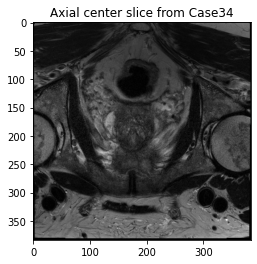

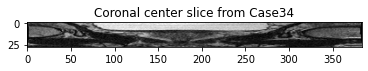

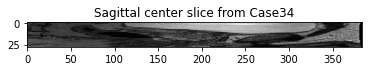

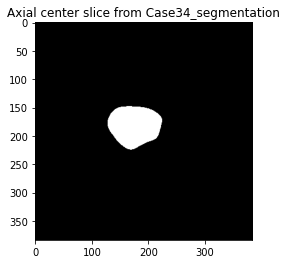

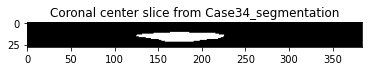

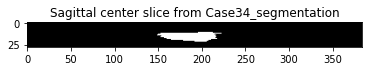


Maximum depth of the volumes...
Max depth of volume Case00 is: 16384
Max depth of volume Case01 is: 512
Max depth of volume Case02 is: 32768
Max depth of volume Case03 is: 32768
Max depth of volume Case04 is: 16384
Max depth of volume Case05 is: 32768
Max depth of volume Case06 is: 32768
Max depth of volume Case07 is: 1024
Max depth of volume Case08 is: 32768
Max depth of volume Case09 is: 32768
Max depth of volume Case10 is: 4096
Max depth of volume Case11 is: 32768
Max depth of volume Case12 is: 16384
Max depth of volume Case13 is: 2048
Max depth of volume Case14 is: 2048
Max depth of volume Case15 is: 4096
Max depth of volume Case16 is: 2048
Max depth of volume Case17 is: 2048
Max depth of volume Case18 is: 2048
Max depth of volume Case19 is: 2048
Max depth of volume Case20 is: 2048
Max depth of volume Case21 is: 4096
Max depth of volume Case22 is: 2048
Max depth of volume Case23 is: 2048
Max depth of volume Case24 is: 2048
Max depth of volume Case25 is: 2048
Max depth of volume Ca

In [ ]:
# Calls to various functions to: (1) display a randomly selected MRI scan, (2) display the corresponding segmentation,
# (3) prints the maximum depth of all volumes, and (4) prints the dimensions of all of the volumes
print("Randomly selected MRI scan and corresponding segementation...")
singleScan(pathToData, 34)
dataset = getData(pathToData)
print("\nMaximum depth of the volumes...")
maxDepth(pathToData, dataset)
print("\n Dimensions of the volumes...")
getAllDimensions(pathToData, dataset)

# PART 2: TRAINING PREPARATION

## Question 2: Data splitting

In [ ]:
'''
The function dataSplitting will split the data into training, testing, and validation sets. The testing set contains one
randomly selected image, while the training and validation sets consist of a random 70:30 split of the remaining images. Optionally,
you can use the hard-coded training/testing/validation sets.
Parameters:
  pathToData: (string) path to the data
Returns:
  trainingData: (list) cases included in the training set
  valData: (list) cases included in the validation set
  testData: (list) case included in the test set
'''
def dataSplitting(pathToData):
    # Load existing training/validation/testing split
    trainingData =   ['Case47', 'Case39', 'Case06', 'Case15', 'Case09', 'Case48', 'Case13', 'Case33', 'Case14', 'Case24', 'Case30', 'Case37', 'Case31', 'Case45', 'Case25', 'Case23', 'Case36', 'Case28', 'Case21', 'Case44', 'Case04', 'Case00', 'Case05', 'Case03', 'Case19', 'Case10', 'Case27', 'Case43', 'Case02', 'Case46', 'Case12', 'Case20', 'Case01']
    valData = ['Case42', 'Case40', 'Case22', 'Case29', 'Case08', 'Case32', 'Case07', 'Case17', 'Case38', 'Case35', 'Case11', 'Case49', 'Case41', 'Case18', 'Case16', 'Case34']
    testingData = ['Case26']
    '''
    # Randomly generate new training/validation/testing sets
    dataset = []
    for filename in glob.glob(pathToData + "/*.npy"):
        if "_segmentation" not in filename:
            dataset.append(os.path.splitext(os.path.basename(filename))[0])
    dataset.sort()

    dataIndexes = list(range(0,len(dataset)))
    random.shuffle(dataIndexes)
        
    testingData = []
    trainingData = []
    valData = []
    split = round((len(dataIndexes)-1)*0.7)
    for i in range(len(dataIndexes)):
        if i == 0:
            testingData.append(dataset[dataIndexes[i]])
        elif i < split:
            trainingData.append(dataset[dataIndexes[i]])
        else:
            valData.append(dataset[dataIndexes[i]])
    '''

    print("The training/testing/validation split is as follows:")
    print("Training data: ", trainingData)
    print("Validation data: ", valData)
    print("Testing data: ", testingData)

    return trainingData, valData, testingData

In [ ]:
trainingData, valData, testingData = dataSplitting(pathToData)

The training/testing/validation split is as follows:
Training data:  ['Case47', 'Case39', 'Case06', 'Case15', 'Case09', 'Case48', 'Case13', 'Case33', 'Case14', 'Case24', 'Case30', 'Case37', 'Case31', 'Case45', 'Case25', 'Case23', 'Case36', 'Case28', 'Case21', 'Case44', 'Case04', 'Case00', 'Case05', 'Case03', 'Case19', 'Case10', 'Case27', 'Case43', 'Case02', 'Case46', 'Case12', 'Case20', 'Case01']
Validation data:  ['Case42', 'Case40', 'Case22', 'Case29', 'Case08', 'Case32', 'Case07', 'Case17', 'Case38', 'Case35', 'Case11', 'Case49', 'Case41', 'Case18', 'Case16', 'Case34']
Testing data:  ['Case26']


## Question 3: Initial Processing

In [ ]:
'''
Applies a square linear filter to a given image. 
    Parameters:
        image (int array): an array of intensity values, which represents an image
        filter (int array): a square filter of any size
    Returns:
        filteredImage (int array): an array of intensity values after a linear filter is applied
'''
def applyFilter(image, filter, numberOfTimes=1):
    smoothedImage = np.shape(image.shape)
    for n in range(numberOfTimes):
        smoothedImage = cv2.filter2D(image,-1,filter)  
    return smoothedImage

'''
Implements a simple contrast enhancement method:
                    0                       if f(m,n) < L1
    g(m,n) = d * ((f(m,n)-L1) / (L2-L1))    if L1 <= f(m,n) <= L2
                    d                       if f(m,n) > L2
        where d is the maximum depth of an image. The maximum depth of the image is determined by calculating
        the closest power of 2 that encompasses the maximum intensity value in the image.

    Parameters:
        image (int array): an array of intensity values, which represents an image
        val1 (int): first value in range at which the values of the image will be enhanced by
        val2 (int): second value in range at which the values of the image will be enhanced by
    Returns:
        enhancedImage (int array): an array of intensity values after a contrast enhancement method is applied
'''
def contrastEnhancement(image, lower, upper):
    maxValue = np.max(image)
    maxDepth = 1
    while maxDepth < maxValue:
        maxDepth *= 2
    lowerThreshold = lower * maxDepth
    upperThreshold = upper * maxDepth
    enhancedImage = np.zeros(image.shape)

    for row in range(image.shape[0]):
        for column in range(image.shape[1]):
            pixelValue = image[row][column]
            if pixelValue >= lowerThreshold and pixelValue < upperThreshold:
                enhancedImage[row][column] = round(maxDepth * (image[row][column] - lowerThreshold) / (upperThreshold - lowerThreshold))
            else:
                enhancedImage[row][column] = maxDepth

    return enhancedImage.astype('uint8')


'''
The function oneHot performs one-hot encoding on the segmentation images. Returned image should be of shape (128,128,2)
Parameters: 
  image: (int array) segmentation image to undergo one-hot encoding
Returns:
  oneHotImage: (int array) segmentation image that is one-hot encoded
'''
def oneHot(image):
  oneHotImage = np.zeros((image.shape[0],image.shape[1],2))
  for row in range(image.shape[0]):
    for column in range(image.shape[1]):
      if image[row][column]==0:
        oneHotImage[row][column][0] = 0
        oneHotImage[row][column][1] = 1
      else:
        oneHotImage[row][column][0] = 1
        oneHotImage[row][column][1] = 0
  
  return oneHotImage


'''
The function initialProcessing performs various processing steps on the MRI scans and corresponding segementations. Images are
loaded, sliced along a specified viewing plane, and resized to reduce spatial resolution. MRI scans are normalized such that all
values fall between 0 and 1. Each processed slice from each volume is added to a list
Parameters:
  pathToData: (string) path to the data
  dataset: (list) dataset of images to be processed
  viewingPlane: (string) plane for volumes to be sliced in
Returns:
  allRawSlices: (list) list of processed MRI scan images
  allSegmentedSlices: (list) list of processed segmented images
'''
def initialProcessing(pathToData, dataset, viewingPlane = "axial"):
    allRawSlices = []
    allSegmentedSlices = []

    for npy in dataset:
        # Load the volumes
        volume = np.load(pathToData + "/" + npy + ".npy")
        segmentedVolume = np.load(pathToData + "/" + npy + "_segmentation.npy")
        # Slice volume along the same plane
        slices = volumeReslicing(volume, viewingPlane)
        segmentedSlices = volumeReslicing(segmentedVolume, viewingPlane)
        for i in range(len(slices)):
            # Reduce the spatial resolution of each slice to 128 x 128 pixels
            processedSlice = cv2.resize(slices[i], (128, 128))
            processedSegmentedSlice = cv2.resize(segmentedSlices[i], (128, 128))
            # Normalize the slice so that it contains only values between 0 and 1
            processedSlice = processedSlice / processedSlice.max()
            # Combine all slices for the set into a single list
            allRawSlices.append(processedSlice)
            allSegmentedSlices.append(processedSegmentedSlice)
    return allRawSlices, allSegmentedSlices

In [ ]:
# Process the images
processedTrainSlices, processedTrainSegmentedSlices = initialProcessing(pathToData, trainingData, "axial")
processedValSlices, processedValSegmentedSlices = initialProcessing(pathToData, valData, "axial")
processedTestSlices, processedTestSegmentedSlices = initialProcessing(pathToData, testingData, "axial")

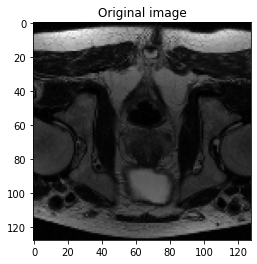

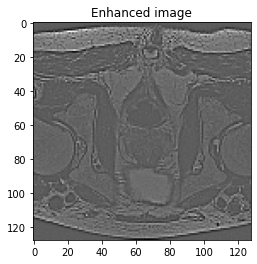

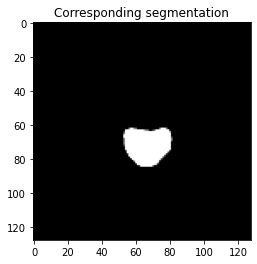

In [ ]:
# Apply enhancement technique(s)
sharpeningFilter = np.array([[-1,-1,-1],[-1,9,-1],[-1,-1,-1]])
smoothingFilter = (1/13.0)*np.array([[1,1,1],[1,5,1],[1,1,1]])

trainImages = []
trainLabels = []
valImages = []
valLabels = []
testImages = []
testLabels = []

for i in range(len(processedTrainSlices)):
  trainImages.append(applyFilter(processedTrainSlices[i], sharpeningFilter, 1))
  trainLabels.append(processedTrainSegmentedSlices[i])
for i in range(len(processedValSlices)):
  valImages.append(applyFilter(processedValSlices[i], sharpeningFilter, 1))
  valLabels.append(processedValSegmentedSlices[i])
for i in range(len(processedTestSlices)):
  testImages.append(applyFilter(processedTestSlices[i], sharpeningFilter, 1))
  testLabels.append(processedTestSegmentedSlices[i])

# Display example enhanced image
sliceNum = random.randint(0,len(processedTrainSlices))
displayImage(processedTrainSlices[sliceNum], "Original image")
displayImage(trainImages[sliceNum], "Enhanced image")
displayImage(trainLabels[sliceNum], "Corresponding segmentation")

In [ ]:
# One-hot encode segmented images
for i in range(len(trainLabels)):
  processedSegmentedSlice = trainLabels[i]
  processedSegmentedSlice = oneHot(processedSegmentedSlice)
  trainLabels[i] = processedSegmentedSlice
for i in range(len(valLabels)):
  processedSegmentedSlice = valLabels[i]
  processedSegmentedSlice = oneHot(processedSegmentedSlice)
  valLabels[i] = processedSegmentedSlice
for i in range(len(testLabels)):
  processedSegmentedSlice = testLabels[i]
  processedSegmentedSlice = oneHot(processedSegmentedSlice)
  testLabels[i] = processedSegmentedSlice

In [ ]:
# Convert lists to numpy array for training
trainImages = np.array(trainImages)
valImages = np.array(valImages)
testImages = np.array(testImages)

trainLabels = np.array(trainLabels)
valLabels = np.array(valLabels)
testLabels = np.array(testLabels)

# PART 3: TRAINING THE MODEL

## Model and associated functions

In [ ]:
'''
Function createUnetModel will create a keras model for segmentation with a unet architecture similar to the structure shown in class
Parameters:
  input_size: (int) The size of the desired input image. Your image must be square, this can be done either with cropping or resizing the image.
  num_classes: (int) The number of classes your network should recognize. This value should include the background class.
Returns:
  model: an uncompiled keras model for segmentation
'''
def createUnetModel(input_size=128, num_classes=2):
    filter_multiplier=10 
    regularization_rate=0.
    input_ = layers.Input((input_size, input_size,1))
    skips = []
    output = input_

    num_layers = int(np.floor(np.log2(input_size)))
    down_conv_kernel_sizes = np.zeros([num_layers], dtype=int)
    down_filter_numbers = np.zeros([num_layers], dtype=int)
    up_conv_kernel_sizes = np.zeros([num_layers], dtype=int)
    up_filter_numbers = np.zeros([num_layers], dtype=int)

    for layer_index in range(num_layers):
        down_conv_kernel_sizes[layer_index] = int(3)
        down_filter_numbers[layer_index] = int((layer_index + 1) * filter_multiplier + num_classes)
        up_conv_kernel_sizes[layer_index] = int(4)
        up_filter_numbers[layer_index] = int((num_layers - layer_index - 1) * filter_multiplier + num_classes)

    for shape, filters in zip(down_conv_kernel_sizes, down_filter_numbers):
        skips.append(output)
        output = layers.Conv2D(filters, (shape, shape), strides=2, padding="same", activation="relu",
                        bias_regularizer=l1(regularization_rate))(output)

    for shape, filters in zip(up_conv_kernel_sizes, up_filter_numbers):
        output = layers.UpSampling2D()(output)
        skip_output = skips.pop()
        output = layers.concatenate([output, skip_output], axis=3)
        if filters != num_classes:
            output = layers.Conv2D(filters, (shape, shape), activation="relu", padding="same",
                            bias_regularizer=l1(regularization_rate))(output)
            output = layers.BatchNormalization(momentum=.9)(output)
        else:
            output = layers.Conv2D(filters, (shape, shape), activation="softmax", padding="same",
                            bias_regularizer=l1(regularization_rate))(output)

    assert len(skips) == 0
    return Model([input_], [output])

'''
Function IoU_loss implements the intersection-over-union loss function for training a segmentation model. This function is to be used as your loss function for question 5, it should be used when you compile your model.
Parameters:
  y_true: The ground truth labelmap. Should have dimensions 
  y_pred: (int) The number of classes your network should recognize. This value should include the background class.
Returns:
  model: an uncompiled keras model for segmentation
'''
def IoU_loss(y_true,y_pred):
    smooth = 1e-12
    intersection = K.sum(y_true[:,:,:,1] * y_pred[:,:,:,1])        #Create intersection
    sum_ = K.sum(y_true[:,:,:,1] + y_pred[:,:,:,1])                #Create union
    jac = (intersection + smooth) / (sum_ - intersection + smooth) #Divide and smooth
    return K.mean(1-jac) #Return 1-IoU so it can be use as a measurement of loss

def IoU(y_true,y_pred):
  IoU = 1 - IoU_loss(y_true,y_pred)
  return IoU

In [ ]:
'''
Function diceCoefficient implements the the Dice Coefficient metric
Parameters:
  y_true: The ground truth labelmap. Should have dimensions (128,128,2)
  y_pred: (int) The number of classes your network should recognize. This value should include the background class
Returns:
  dice: (int) measure of similarity between the two sets of data
'''
def diceCoefficient(y_true, y_pred):
  intersection = K.sum(y_true[:,:,:,1] * y_pred[:,:,:,1]) # Get intersection
  totalPixels = K.sum(y_true[:,:,:,1]) + K.sum(y_pred[:,:,:,1]) 
  dice = tensorflow.cast((2*intersection), tensorflow.float32) / tensorflow.cast(totalPixels, tensorflow.float32)
  return dice

In [ ]:
'''
The function plotModelMetric displays the training vs validation metric of choice
Parameters:
  model: trained keras model for segmentation
  metric: (string) metric to be displayed (ex. accuracy, IoU, diceCoefficient)
  lowerBound: (int) lower bound of plot
  upperBound: (int) upper bound of plot
'''
def plotModelMetric(model, metric='accuracy', lowerBound=0.5, upperBound=1):
  plt.plot(model.history[metric], label=metric)
  plt.plot(model.history['val_'+metric], label = 'val_'+metric)
  plt.xlabel('Epoch')
  plt.ylabel(metric)
  plt.ylim([lowerBound, upperBound])
  plt.legend(loc='lower right')

## Question 4: Cross-entropy loss

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 12)   120         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 32, 32, 22)   2398        ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 16, 16, 32)   6368        ['conv2d_1[0][0]']           

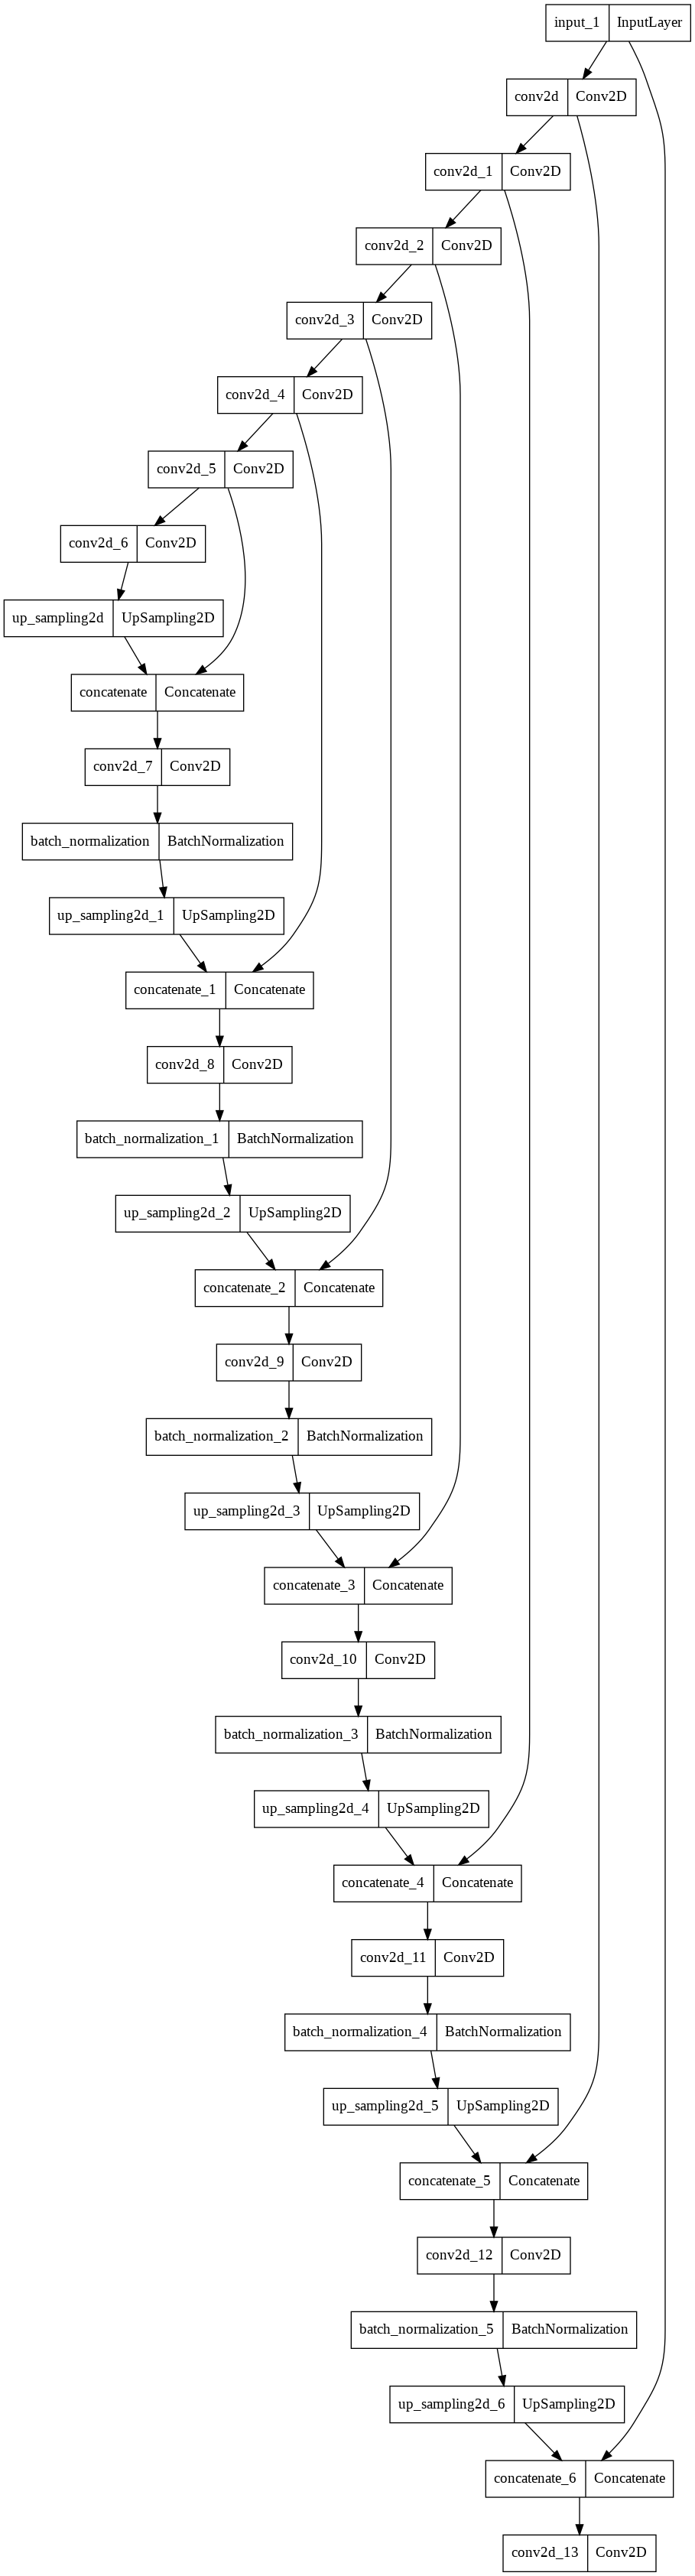

In [ ]:
# Create model
modelQ4 = createUnetModel()
print(modelQ4.summary())
tensorflow.keras.utils.plot_model(modelQ4)

In [ ]:
# Compile model
modelQ4.compile(tensorflow.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy',
              metrics=['accuracy',IoU, diceCoefficient])

In [ ]:
# Train model with callback option
cp_callback = tensorflow.keras.callbacks.ModelCheckpoint(
    filepath=pathToQ4Weights, 
    verbose=1, 
    save_weights_only=True,
    save_best_only=True)

historyQ4 = modelQ4.fit(trainImages, trainLabels, epochs=40, batch_size=16, shuffle=True,
                    callbacks=[cp_callback], validation_data=(valImages, valLabels))

Epoch 1/40
59/59 [==============================] - ETA: 0s - loss: 0.7200 - accuracy: 0.5979 - IoU: 0.5080 - diceCoefficient: 0.6737
Epoch 1: val_loss improved from inf to 0.63380, saving model to /content/drive/MyDrive/CISC472/Q4/Weights
59/59 [==============================] - 18s 96ms/step - loss: 0.7200 - accuracy: 0.5979 - IoU: 0.5080 - diceCoefficient: 0.6737 - val_loss: 0.6338 - val_accuracy: 0.7514 - val_IoU: 0.5325 - val_diceCoefficient: 0.6949
Epoch 2/40
59/59 [==============================] - ETA: 0s - loss: 0.6485 - accuracy: 0.7482 - IoU: 0.5276 - diceCoefficient: 0.6908
Epoch 2: val_loss improved from 0.63380 to 0.61308, saving model to /content/drive/MyDrive/CISC472/Q4/Weights
59/59 [==============================] - 3s 55ms/step - loss: 0.6485 - accuracy: 0.7482 - IoU: 0.5276 - diceCoefficient: 0.6908 - val_loss: 0.6131 - val_accuracy: 0.7951 - val_IoU: 0.5478 - val_diceCoefficient: 0.7078
Epoch 3/40
59/59 [==============================] - ETA: 0s - loss: 0.6043 - ac

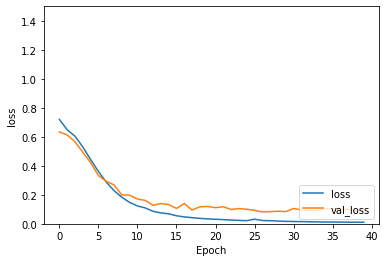

In [ ]:
plotModelMetric(historyQ4, 'loss', 0, 1.5)

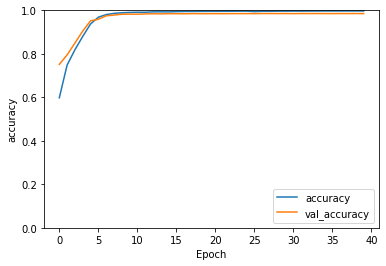

In [ ]:
plotModelMetric(historyQ4, 'accuracy', 0, 1)

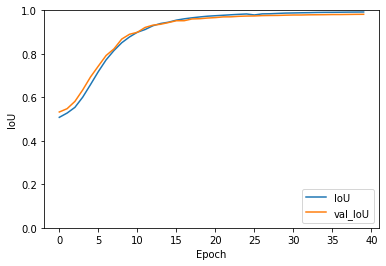

In [ ]:
plotModelMetric(historyQ4, 'IoU', 0, 1)

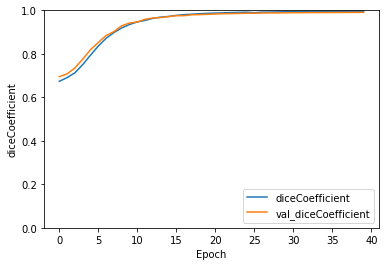

In [ ]:
plotModelMetric(historyQ4, 'diceCoefficient', 0, 1)

## Question 5: IoU loss

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_14 (Conv2D)             (None, 64, 64, 12)   120         ['input_2[0][0]']                
                                                                                                  
 conv2d_15 (Conv2D)             (None, 32, 32, 22)   2398        ['conv2d_14[0][0]']              
                                                                                                  
 conv2d_16 (Conv2D)             (None, 16, 16, 32)   6368        ['conv2d_15[0][0]']        

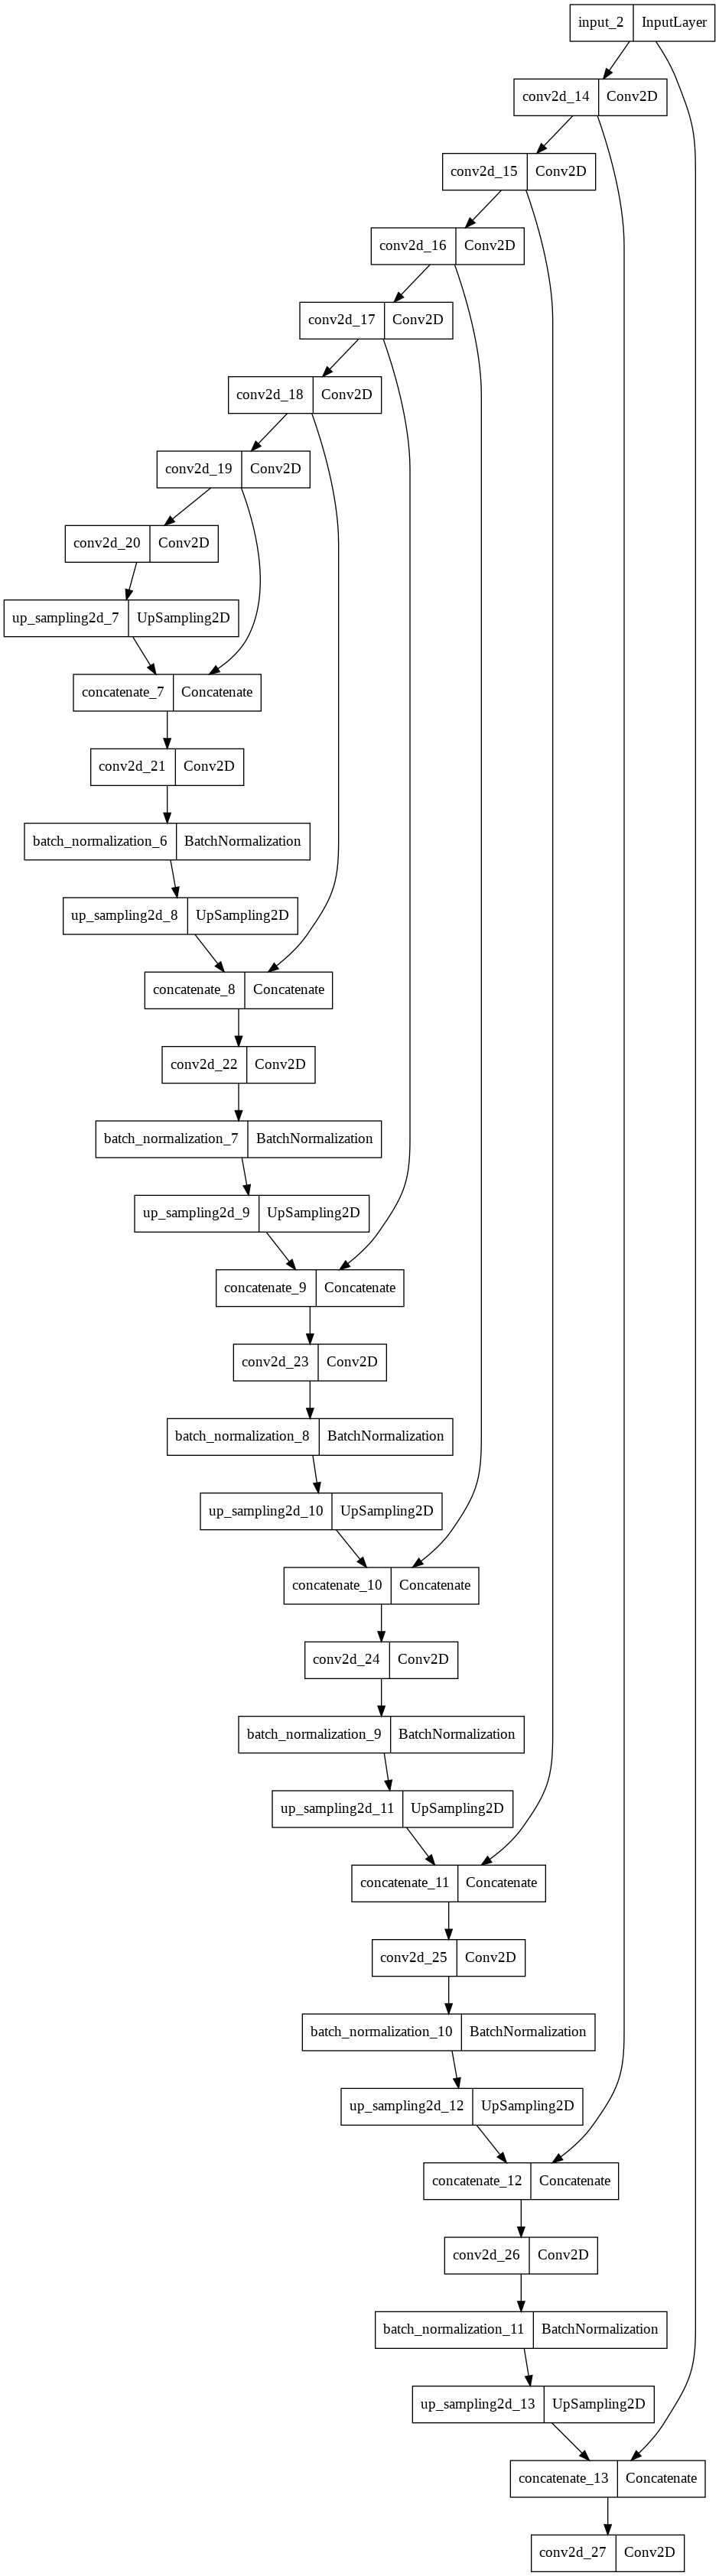

In [ ]:
# Create model
modelQ5 = createUnetModel()
print(modelQ5.summary())
tensorflow.keras.utils.plot_model(modelQ5)

In [ ]:
# Compile model
modelQ5.compile(tensorflow.keras.optimizers.Adam(learning_rate=0.0001), loss=IoU_loss,
              metrics=['accuracy',IoU, diceCoefficient])

In [ ]:
# Train model with callback option
cp_callback = tensorflow.keras.callbacks.ModelCheckpoint(
    filepath=pathToQ5Weights, 
    verbose=1, 
    save_weights_only=True,
    save_best_only=True)

historyQ5 = modelQ5.fit(trainImages, trainLabels, epochs=40, batch_size=8, shuffle=True,
                    callbacks=[cp_callback], validation_data=(valImages, valLabels))

Epoch 1/40
118/118 [==============================] - ETA: 0s - loss: 0.2916 - accuracy: 0.7964 - IoU: 0.7087 - diceCoefficient: 0.8266
Epoch 1: val_loss improved from inf to 0.17379, saving model to /content/drive/MyDrive/CISC472/Q5/Weights
118/118 [==============================] - 9s 50ms/step - loss: 0.2916 - accuracy: 0.7964 - IoU: 0.7087 - diceCoefficient: 0.8266 - val_loss: 0.1738 - val_accuracy: 0.8877 - val_IoU: 0.8266 - val_diceCoefficient: 0.9041
Epoch 2/40
117/118 [============================>.] - ETA: 0s - loss: 0.1622 - accuracy: 0.8950 - IoU: 0.8378 - diceCoefficient: 0.9116
Epoch 2: val_loss improved from 0.17379 to 0.12434, saving model to /content/drive/MyDrive/CISC472/Q5/Weights
118/118 [==============================] - 4s 33ms/step - loss: 0.1621 - accuracy: 0.8951 - IoU: 0.8380 - diceCoefficient: 0.9117 - val_loss: 0.1243 - val_accuracy: 0.9183 - val_IoU: 0.8756 - val_diceCoefficient: 0.9336
Epoch 3/40
117/118 [============================>.] - ETA: 0s - loss: 0.

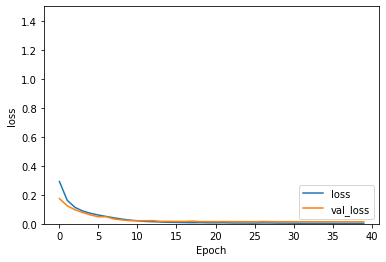

In [ ]:
plotModelMetric(historyQ5, 'loss', 0, 1.5)

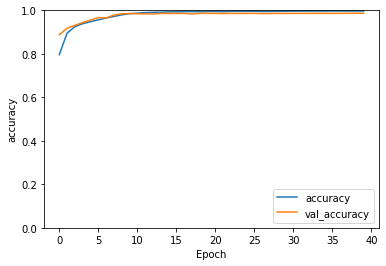

In [ ]:
plotModelMetric(historyQ5, 'accuracy', 0, 1)

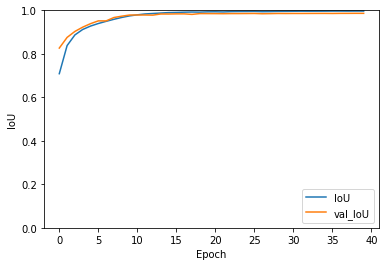

In [ ]:
plotModelMetric(historyQ5, 'IoU',0, 1)

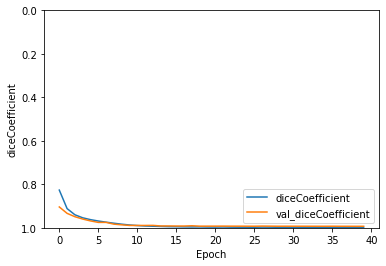

In [ ]:
plotModelMetric(historyQ5, 'diceCoefficient', 1, 0)

# PART 4: EVALUATE THE MODEL

## Question 6: Qualitative evaluation

In [ ]:
'''
Function rerecombineVolume combines the slices of a 4D array into one volume/3D array, which can then be saved 
as a numpy volume and viewed in 3D Slicer. 
Parameters:
  arr: 4D array to be combined into a volume
Returns:
  vol: 3D array/volume
'''
def recombineVolume(arr):
  vol = np.zeros((arr.shape[0],arr.shape[1],arr.shape[2]))
  for z in range(arr.shape[0]):
    for y in range(arr.shape[1]):
      for x in range(arr.shape[2]):
        val = [(1 if x > 0.5 else 0) for x in arr[z][y][x]]
        if val[0]==0 and val[1]==1:
            vol[z][y][x] = 0
        elif val[0]==1 and val[1]==0:
            vol[z][y][x] = 1
  return vol

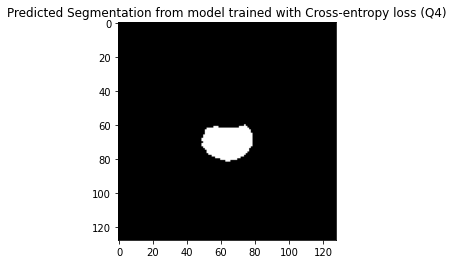

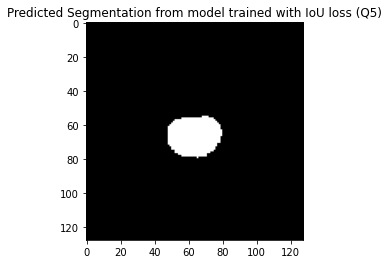

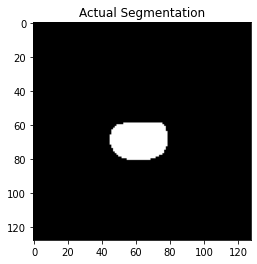

In [ ]:
# Get predictions and convert to 3D array
groundTruth = recombineVolume(testLabels) # Only one test image so do not need dimensions to recombine volume
prediction_Q4 = recombineVolume(modelQ4.predict(testImages))
prediction_Q5 = recombineVolume(modelQ5.predict(testImages))

# Save predicted segmentations
np.save("predictedSegmentation_Q4.npy", prediction_Q4)
np.save("predictedSegmentation_Q5.npy", prediction_Q5)

# Display a slice from the predicted segmentation, as well as the ground truth
displayImage(prediction_Q4[10], "Predicted Segmentation from model trained with Cross-entropy loss (Q4)")
displayImage(prediction_Q5[10], "Predicted Segmentation from model trained with IoU loss (Q5)")
displayImage(groundTruth[10], "Actual Segmentation")

## Question 7: Quantitative evaluation

In [ ]:
'''
Function avgPrecision calculate the average precision overall and for each class given the predicted segmentation and
ground truth. Initially calculates the confusion matrix, which is then used to calulcate precision.
Parameters:
  y_pred: (3D array) predicted segmentation as a volume
  y_true: (3D array) ground truth segmentation as a volume
Returns:
  precision_c0: (float) precision of class 0
  precision_c1: (float) precision of class 1
  precision_macro: (float) overall precision
'''
def avgPrecision(y_pred, y_true):
  y_pred_flat = y_pred.flatten()
  y_true_flat = y_true.flatten()

  c_matrix = np.zeros((2, 2))
  for i in range(len(y_true_flat)):
    c_matrix[int(y_true_flat[i])][int(y_pred_flat[i])] += 1
  
  tp_class0, fn_class0, fp_class0, tn_class0 = np.ravel(c_matrix) # (0,0) considered true positive
  tn_class1, fp_class1, fn_class1, tp_class1 = np.ravel(c_matrix) # (1,1) considered true positive

  precision_c0 = tp_class0 / (tp_class0 + fp_class0)
  precision_c1 = tp_class1 / (tp_class1 + fp_class1)
  macro_precision = (precision_c0 + precision_c1) / 2

  return precision_c0, precision_c1, macro_precision


'''
Function avgRecall calculate the average recall overall and for each class given the predicted segmentation and
ground truth. Initially calculates the confusion matrix, which is then used to calulcate recall.
Parameters:
  y_pred: (3D array) predicted segmentation as a volume
  y_true: (3D array) ground truth segmentation as a volume
Returns:
  recall_c0: (float) recall of class 0
  recall_c1: (float) recall of class 1
  recall_macro: (float) overall recall
'''
def avgRecall(y_pred, y_true):
  y_pred_flat = y_pred.flatten()
  y_true_flat = y_true.flatten()
  
  c_matrix = np.zeros((2, 2))
  for i in range(len(y_true_flat)):
    c_matrix[int(y_true_flat[i])][int(y_pred_flat[i])] += 1
  
  tp_class0, fn_class0, fp_class0, tn_class0 = np.ravel(c_matrix) # (0,0) considered true positive
  tn_class1, fp_class1, fn_class1, tp_class1 = np.ravel(c_matrix) # (1,1) considered true positive

  recall_c0 = tp_class0 / (tp_class0 + fn_class0)
  recall_c1 = tp_class1 / (tp_class1 + fn_class1)
  macro_recall = (recall_c0 + recall_c1) / 2

  return recall_c0, recall_c1, macro_recall


'''
Function avgHausdorff calculate the average hausdorff distance given the predicted segmentation and ground truth. 
Uses scipy.spatial.distance.directed_hausdorff(u, v, seed=0) to compute the directed Hausdorff distance between 
two 2D arrays.
Parameters:
  y_pred: (3D array) predicted segmentation as a volume
  y_true: (3D array) ground truth segmentation as a volume
Returns:
  avgDist: (float) average hausdorff distance
'''
def avgHausdorff(y_pred, y_true):
  avgDist = 0
  for i in range(len(y_pred)):
    avgDist += directed_hausdorff(y_pred[i], y_true[i])[0]

  avgDist = avgDist / len(y_pred)
  return avgDist

In [ ]:
# Calculate precision
precision_c0, precision_c1, macro_precision = avgPrecision(prediction_Q4, groundTruth)
print("Precision for model trained with cross-entropy loss:\n Average precision for class 0: {0}\n \
Average precision for class 1: {1}\n \
Average precision overall: {2}".format(precision_c0, precision_c1, macro_precision))

precision_c0, precision_c1, macro_precision = avgPrecision(prediction_Q5, groundTruth)
print("Precision for model trained with IoU loss:\n Average precision for class 0: {0}\n \
Average precision for class 1: {1}\n \
Average precision overall: {2}".format(precision_c0, precision_c1, macro_precision))

# Calculate recall
recall_c0, recall_c1, macro_recall = avgRecall(prediction_Q4, groundTruth)
print("\nRecall for model trained with cross-entropy loss:\n Average recall for class 0: {0}\n \
Average recall for class 1: {1}\n \
Average recall overall: {2}".format(recall_c0, recall_c1, macro_recall))

recall_c0, recall_c1, macro_recall = avgRecall(prediction_Q5, groundTruth)
print("Recall for model trained with IoU loss:\n Average recall for class 0: {0}\n \
Average recall for class 1: {1}\n \
Average recall overall: {2}".format(recall_c0, recall_c1, macro_recall))

# Calculate Hausdorff distance
hausdorffDist = avgHausdorff(prediction_Q4, groundTruth)
print("\nHausdorff distance for model trained with cross-entropy loss: {0}".format(hausdorffDist))

hausdorffDist = avgHausdorff(prediction_Q5, groundTruth)
print("Hausdorff distance for model trained with IoU loss: {0}".format(hausdorffDist))

Precision for model trained with cross-entropy loss:
 Average precision for class 0: 0.993518426341718
 Average precision for class 1: 0.9254309509974821
 Average precision overall: 0.9594746886696001
Precision for model trained with IoU loss:
 Average precision for class 0: 0.9940168998236446
 Average precision for class 1: 0.6983436271757439
 Average precision overall: 0.8461802634996942

Recall for model trained with cross-entropy loss:
 Average recall for class 0: 0.9989584601441924
 Average recall for class 1: 0.6648114651454015
 Average recall overall: 0.8318849626447969
Recall for model trained with IoU loss:
 Average recall for class 0: 0.9941863138957648
 Average recall for class 1: 0.6922220676220955
 Average recall overall: 0.8432041907589302

Hausdorff distance for model trained with cross-entropy loss: 1.7636629303771276
Hausdorff distance for model trained with IoU loss: 1.798228679335909


/usr/local/lib/python3.7/dist-packages/scipy/spatial/distance.py:456: UserWarning: you are shuffling a '_memoryviewslice' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  result = _hausdorff.directed_hausdorff(u, v, seed)
